# **Multi-Objective Variational Autoencoder with 3D Dataset**

## Prepare necessary libraries and build dataset

In [ ]:
# ================== IMPORT LIBRARIES ==================
import os

# This allow a silent import of Tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
import json
from statistics import mean
from google_drive_downloader import GoogleDriveDownloader

from IPython import display

print("Successfully Load All Libraries - Tensorflow Version {}".format(tf.__version__))

In [4]:
# ================= SET UP PARAMETERS ==================

# The latent dimension of the variational autoencoder network
latent_dimension = 10

# During the training, a number of samples using random latent values will be generated. This defines how many number of samples we want to generate
num_examples_to_generate = 25

# Epochs
epochs = 50

# Batch size
batch_size = 32

# Learning rate
learning_rate = 1e-6

# Path of the directory where all the Json files are saved. 
data_files_directory = './data/chair_voxel_dataset/'


# Path of the directory where the pretrained weights of the vae will be loaded from. 
vae_load_location = './data/pretrained_models/chair_vae/epoch_100'

# Path of the directory where the pretrained weights of the stability auxiliary discriminator will be loaded from. 
stability_auxiliary_discriminator_load_location = './data/pretrained_models/chair_stability_auxiliary_discriminator/epoch_50'

# Path of the directory where the pretrained weights of the aesthetic auxiliary discriminator will be loaded from. 
aesthetic_auxiliary_discriminator_load_location = './data/pretrained_models/chair_aesthetic_auxiliary_discriminator/epoch_50'

# Path of the directory where the pretrained weights of the function auxiliary discriminator will be loaded from. 
function_auxiliary_discriminator_load_location = './data/pretrained_models/chair_function_auxiliary_discriminator/epoch_50'

# Path of the directory where the trained weights of the network will be saved. 
mo_vae_save_directory = './movae_train/saved_models/'

# Create the directory to save the trained weights of the network. 
try:
    os.makedirs(mo_vae_save_directory)
except FileExistsError:
    print("The directory to save trained network weights already exists")

# The path of log file that contains training information. 
mo_vae_training_log_location = './movae_train/logs.txt'

# Create a txt file to save losses during training
try:
    log_file = open(mo_vae_training_log_location, "x")
    log_file.close()
except FileExistsError:
    print("Log file already exists")
    
# During the training, a number of samples using random latent values will be generated. This defines where these generated samples will be saved
directory_to_generated_samples = './movae_train/samples/'

try:
    os.makedirs(directory_to_generated_samples)
except FileExistsError:
    print("The directory to save generated samples already exists")

Download the dataset. 
Each file is a JSON file that contains information of the geometry we converted from the ShapeNet dataset and the related ratings. 

The JSON file should have following properties: 

*   "geometry":  a multi-dimension array to represent the geometry. 
*   "voxel_size": the size of each voxels (should always equal to 1 in the context of this notebook)
*   "scaling_factor_from_original": the scaling factor we used to scale the original mesh to produce this geometry
*   "geometry_shape": a list representing the shape of the geometry. (should always be [32, 32, 64] in the context of this notebook)

Ratings in the JSON files are as following: 

If the geometry is not given one of the ratings, the properties will note null
*   "stability_rating": the stability rating as a float from 0 to 1
*   "aesthetic_rating": the aesthetic rating as an integer from 0 to 10
*   "function_rating": the function rating as an integer from 0 to 10

Although the aesthetic_rating and function_rating are from 0 to 10 in the dataset. They should be normalized for the training, including the pretrained network should also produce a normalized rating. 

In [3]:
# If the directory exists and is not empty we presume the dataset is already on the local drive. 
# If not, we will download the dataset. 

download_dataset_from_google_drive = False

if os.path.isdir(data_files_directory):
    if not os.listdir(data_files_directory):
        # Directory is empty
        download_dataset_from_google_drive = True
    else:    
        # Directory is not empty
        download_dataset_from_google_drive = False
else:
    # Given directory doesn't exist
    download_dataset_from_google_drive = True
    
if download_dataset_from_google_drive:

    # This will get download all the json files that contain geometry and rating information from google drive to the destination directory
    GoogleDriveDownloader.download_file_from_google_drive(file_id='1DJzSfSWUDkAhuEfu706pm0riC6ho_5NS', 
                                                          dest_path=os.path.join(data_files_directory, 'chair_voxel_dataset.zip'),
                                                          unzip=True)
    data_files_directory = data_files_directory + 'chair_voxel_dataset/'

Unzipping...Done.


In [5]:
# Get all the json file paths from the unzippped directory. 
data_file_paths = glob.glob(data_files_directory + "*.json")

In [6]:
data_files_with_stability_rating = []
data_files_with_aesthetic_rating = []
data_files_with_function_rating = []

for data_file in data_file_paths:
    with open(data_file) as json_file:
        dictionary = json.load(json_file)
        if dictionary["stability_rating"] != None:
            data_files_with_stability_rating.append(data_file)
        if dictionary["aesthetic_rating"] != None:
            data_files_with_aesthetic_rating.append(data_file)
        if dictionary["function_rating"] != None:
            data_files_with_function_rating.append(data_file)

In [7]:
print("There are {} json files in total. ".format(len(data_file_paths)))
print("There are {} files that have stability rating. ".format(len(data_files_with_stability_rating)))
print("There are {} files that have aesthetic rating. ".format(len(data_files_with_aesthetic_rating)))
print("There are {} files that have function rating. ".format(len(data_files_with_function_rating)))

There are 6777 json files in total. 
There are 6777 files that have stability rating. 
There are 2724 files that have aesthetic rating. 
There are 2000 files that have function rating. 


In [8]:
# Define how many samples will be used for training
num_training_samples = 4750  # 4750

# Define how many samples will be used for validation
num_validation_samples = 2027  # 2027

Define several helper functions below that will facilitate building the tensorflow dataset. 

In [31]:
# ================= HELPER FUNCTIONS ===================
# This function can preview a geometry data using matplot lib
def preview_geometries(geometry_data, plot_threshold=0.25, stability_model=None, aesthetic_model=None, function_model=None, save_plot_as_png=False, path_to_save=None):
    # geometry_data must be an array of shape [32, 32, 64, 1]
    if stability_model is not None:
        stability_prediction = np.array(stability_model(np.expand_dims(geometry_data, axis=0)))[0][0]
    else:
        stability_prediction = None
    
    if aesthetic_model is not None:
        aesthetic_prediction = np.array(aesthetic_model(np.expand_dims(geometry_data, axis=0)))[0][0]
    else:
        aesthetic_prediction = None
    
    if function_model is not None:
        function_prediction = np.array(function_model(np.expand_dims(geometry_data, axis=0)))[0][0]
    else:
        function_prediction = None
    
    generation_title = "Stability Prediction is {}\nAesthetic Prediction is {}\nFunction Prediction is {}".format(str(stability_prediction), str(aesthetic_prediction), str(function_prediction))

    x = []
    y = []
    z = []

    data = np.squeeze(geometry_data, axis=-1)
    for i in range(0, len(data)):
        for j in range(0, len(data[i])):
            for k in range(0, len(data[i][j])):
                if data[i][j][k] >= plot_threshold:
                    x.append(i)
                    y.append(j)
                    z.append(k)

    z_c = z

    # We decided to plot the results with a gradient color map so the depth and geometries are clearer to see. 
    from matplotlib.colors import ListedColormap

    N = 256
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(1, 0, N)
    vals[:, 1] = np.linspace(43/N, 43/N, N)
    vals[:, 2] = np.linspace(82/N, 82/N, N)
    custom_cmp = ListedColormap(vals)

    fig = plt.figure(figsize=(5,5))
    fig = plt.axes(projection='3d')
    
    # Data for three-dimensional scattered points
    fig.scatter3D(np.array(x), np.array(y) * -1, np.array(z), cmap=custom_cmp, c=z_c)
    fig.set_zlim(0,64)
    fig.set_ylim(-64,0)
    fig.set_xlim(0,64)
    plt.title(generation_title);
    if (save_plot_as_png):
        plt.savefig(path_to_save + '.png')
  
    plt.show()
    return plt

# This function reads a custom dictionary data
def read_json_file_geometry(filepath):
    with open(filepath.numpy()) as json_file:
        dictionary = json.load(json_file)

    tensor = tf.convert_to_tensor(np.array(dictionary["geometry"]), dtype=tf.float32)
    tensor = tf.expand_dims(tensor, -1)
    return tensor

# Function to build dataset without labels
def build_dataset_wo_labels(filepaths, batch_size):
    file_list = tf.data.Dataset.list_files(filepaths)
    ds = file_list.map(lambda x: tf.py_function(read_json_file_geometry, [x], Tout=tf.float32))
    ds = ds.shuffle(4, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(4)
    return ds

In [10]:
# Build tensorflow dataset

train_ds = build_dataset_wo_labels(data_file_paths[0:num_training_samples], batch_size)
val_ds = build_dataset_wo_labels(data_file_paths[num_training_samples:num_training_samples + num_validation_samples], batch_size)

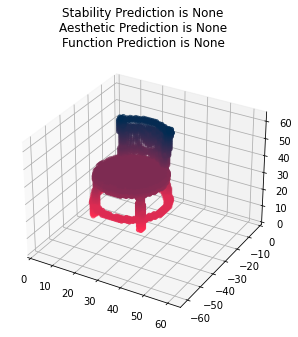

In [32]:
# We can preview the first geometry in first batch as following

for each_batch in train_ds:
    preview_geometries(each_batch[0], plot_threshold=0.25, stability_model=None, aesthetic_model=None, function_model=None, save_plot_as_png=False, path_to_save=None)
    break

## Load pretrained networks for multi-objective variational autoencoder training

Build the variational autoencoder network and load the pretrained weights. 

The weights to load must match structure as the network. 

In [12]:
# ================ SET UP MACHINE LEARNING MODELS =========
class Conv3DVariationalAutoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Conv3DVariationalAutoencoder, self).__init__()  #

        self.latent_dim = latent_dim
        self.encoder_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=[32, 32, 64, 1]),

                tf.keras.layers.Conv3D(filters=32, kernel_size=(5, 5, 5), strides=(1, 1, 1), padding="same", activation='relu'),
                # 32*32*64*32
                tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2)),
                # 16x16x32*32

                tf.keras.layers.Conv3D(filters=64, kernel_size=(5, 5, 5), strides=(1, 1, 1), padding="same", activation='relu'),
                # 16x16x32*64
                tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2)),
                # 8x8x16*64

                tf.keras.layers.Conv3D(filters=128, kernel_size=(5, 5, 5), strides=(1, 1, 1), padding="same", activation='relu'),
                # 8x8x16*128
                tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2)),
                # 4x4x8*128

                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),

                tf.keras.layers.Dense(units=4*4*8*128, activation='relu'),
                tf.keras.layers.Reshape(target_shape=(4, 4, 8, 128)),

                tf.keras.layers.Conv3DTranspose(filters=128, kernel_size=(5, 5, 5), strides=(2, 2, 2), padding="same", activation='relu'),
                tf.keras.layers.Conv3DTranspose(filters=64, kernel_size=(5, 5, 5), strides=(2, 2, 2), padding="same", activation='relu'),
                tf.keras.layers.Conv3DTranspose(filters=32, kernel_size=(5, 5, 5), strides=(2, 2, 2), padding="same", activation='relu'),
                tf.keras.layers.Conv3DTranspose(filters=1, kernel_size=(5, 5, 5), padding="same"),
            ]
        )


    def call(self, inp):
        return self.sample_from_input(inp)

    def sample_from_latent(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=False)

    def sample_from_input(self, input_data):
        mean, logvar = self.encode(input_data)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decode(z, apply_sigmoid=True)
        return reconstruction

    def encode(self, x):
        mean, logvar = tf.split(self.encoder_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits

In [13]:
conv3d_vae = Conv3DVariationalAutoencoder(latent_dimension)

conv3d_vae.build((batch_size, 32, 32, 64, 1))
conv3d_vae.summary()

Model: "conv3d_variational_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 20)                1611924   
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 64, 1)     3512449   
Total params: 5,124,373
Trainable params: 5,124,373
Non-trainable params: 0
_________________________________________________________________


In [14]:
try:
    conv3d_vae.load_weights(vae_load_location)
    
# If the pretrained weights cannot be loaded from the directory, we download the weights from google drive trained by researchers. 
except:
    GoogleDriveDownloader.download_file_from_google_drive(file_id='115-OIdZWlt3WCr0IIJx1fcVnhcHDcZ5u', 
                                                          dest_path='./data/pretrained_models/chair_vae.zip',
                                                          unzip=True)
    conv3d_vae.load_weights('./data/pretrained_models/chair_vae/epoch_100')
    
print("Successfully loaded vae weights")

Unzipping...Done.
Successfully loaded vae weights


Build the stability auxiliary discriminator network and load the pretrained weights.

The weights to load must match structure as the network.

In [15]:
stability_auxiliary_discriminator_model = tf.keras.Sequential(
  [
    tf.keras.layers.Conv3D(16, (4, 4, 4), strides=(2, 2, 2), padding='same', input_shape=(32, 32, 64, 1)), 
    tf.keras.layers.LeakyReLU(), 
    tf.keras.layers.Dropout(0.3), 

    tf.keras.layers.Conv3D(32, (4, 4, 4), strides=(2, 2, 2), padding='same'), 
    tf.keras.layers.LeakyReLU(), 
    tf.keras.layers.Dropout(0.3), 

    tf.keras.layers.Conv3D(64, (4, 4, 4), strides=(2, 2, 2), padding='same'), 
    tf.keras.layers.LeakyReLU(), 
    tf.keras.layers.Dropout(0.3), 

    tf.keras.layers.Conv3D(128, (4, 4, 4), strides=(2, 2, 2), padding='same'), 
    tf.keras.layers.LeakyReLU(), 
    tf.keras.layers.Dropout(0.3), 

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1), 
  ]
)

In [16]:
try:
    stability_auxiliary_discriminator_model.load_weights(stability_auxiliary_discriminator_load_location)
    
# If the pretrained weights cannot be loaded from the directory, we download the weights from google drive trained by researchers. 
except:
    GoogleDriveDownloader.download_file_from_google_drive(file_id='1vIW-uBJpXoqgZ5vwRGRdXOTKP5GEIuXs', 
                                                          dest_path='./data/pretrained_models/chair_stability_auxiliary_discriminator.zip',
                                                          unzip=True)
    stability_auxiliary_discriminator_model.load_weights('./data/pretrained_models/chair_stability_auxiliary_discriminator/epoch_50')
    
print("Successfully loaded stability auxiliary discriminator weights")

Unzipping...Done.
Successfully loaded stability auxiliary discriminator weights


Build the aesthetic auxiliary discriminator network and load the pretrained weights.

The weights to load must match structure as the network.

In [17]:
aesthetic_auxiliary_discriminator_model = tf.keras.Sequential(
  [
    tf.keras.layers.Conv3D(16, (4, 4, 4), strides=(2, 2, 2), padding='same', input_shape=(32, 32, 64, 1)), 
    tf.keras.layers.LeakyReLU(), 
    tf.keras.layers.Dropout(0.3), 

    tf.keras.layers.Conv3D(32, (4, 4, 4), strides=(2, 2, 2), padding='same'), 
    tf.keras.layers.LeakyReLU(), 
    tf.keras.layers.Dropout(0.3), 

    tf.keras.layers.Conv3D(64, (4, 4, 4), strides=(2, 2, 2), padding='same'), 
    tf.keras.layers.LeakyReLU(), 
    tf.keras.layers.Dropout(0.3), 

    tf.keras.layers.Conv3D(128, (4, 4, 4), strides=(2, 2, 2), padding='same'), 
    tf.keras.layers.LeakyReLU(), 
    tf.keras.layers.Dropout(0.3), 

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1), 
  ]
)

In [18]:
try:
    aesthetic_auxiliary_discriminator_model.load_weights(aesthetic_auxiliary_discriminator_load_location)
    
# If the pretrained weights cannot be loaded from the directory, we download the weights from google drive trained by researchers. 
except:
    GoogleDriveDownloader.download_file_from_google_drive(file_id='1Oq3a1s6_CDbpQUc102r4eX6g8oMsHqBu', 
                                                          dest_path='./data/pretrained_models/chair_aesthetic_auxiliary_discriminator.zip',
                                                          unzip=True)
    aesthetic_auxiliary_discriminator_model.load_weights('./data/pretrained_models/chair_aesthetic_auxiliary_discriminator/epoch_50')
    
print("Successfully loaded aesthetic auxiliary discriminator weights")

Unzipping...Done.
Successfully loaded aesthetic auxiliary discriminator weights


Build the function auxiliary discriminator network and load the pretrained weights.

The weights to load must match structure as the network.

In [19]:
function_auxiliary_discriminator_model = tf.keras.Sequential(
  [
    tf.keras.layers.Conv3D(16, (4, 4, 4), strides=(2, 2, 2), padding='same', input_shape=(32, 32, 64, 1)), 
    tf.keras.layers.LeakyReLU(), 
    tf.keras.layers.Dropout(0.3), 
   
    tf.keras.layers.Conv3D(32, (4, 4, 4), strides=(2, 2, 2), padding='same'), 
    tf.keras.layers.LeakyReLU(), 
    tf.keras.layers.Dropout(0.3), 
   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1), 
  ]
)

In [20]:
try:
    function_auxiliary_discriminator_model.load_weights(function_auxiliary_discriminator_load_location)
    
# If the pretrained weights cannot be loaded from the directory, we download the weights from google drive trained by researchers. 
except:
    GoogleDriveDownloader.download_file_from_google_drive(file_id='1P7Y6gs0L3aa2kYv3M4N0uVy2ypBk16Z0', 
                                                          dest_path='./data/pretrained_models/chair_function_auxiliary_discriminator.zip',
                                                          unzip=True)
    function_auxiliary_discriminator_model.load_weights('./data/pretrained_models/chair_function_auxiliary_discriminator/epoch_50')
    
print("Successfully loaded function auxiliary discriminator weights")

Unzipping...Done.
Successfully loaded function auxiliary discriminator weights


## Train the multi-objective variational autoencoder

Define the expectations for each category (the values are normalized)

Define the LAMBDA value (the weight) of each category. Because these weights are relative to the reconstruction score of the encoder, the researchers experimented with these numbers. 

In [21]:
stability_expectation = 0.05
aesthetic_expectation = 0.05
function_expectation = 0.85

In [22]:
LAMBDA_obj = [50000, 60000, 60000]  # [stability, aesthetic, function]

In [23]:
log_file = open(mo_vae_training_log_location, "w")
log_file.write("Expectation Values for [stability, aesthetic, function]: {}".format([stability_expectation, aesthetic_expectation, function_expectation]))
log_file.write('\n')
log_file.write("Lambda Values for [stability, aesthetic, function]: {}".format(LAMBDA_obj))
log_file.write('\n')
log_file.write("Learning Rate for this training: {}".format(learning_rate))
log_file.close()

In [24]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def compute_loss(model, original, label):
    mean, logvar = model.encode(original)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=label)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


def compute_mo_vae_loss(generation_loss, obj_discriminator_pred, LAMBDA_obj, obj_discriminator_exp):
    # vae_loss = compute_loss(model, original, label)
    
    # objective discriminator loss using mean absolute error
    discriminator_obj_loss = tf.reduce_mean(tf.abs(obj_discriminator_pred - obj_discriminator_exp), axis=0)

    if len(LAMBDA_obj) == 1:
        weighted_discriminator_obj_loss = tf.math.reduce_sum(LAMBDA_obj[0] * discriminator_obj_loss)
    else:
        weighted_disc_obj_losses_as_tensor = tf.math.multiply(tf.cast(LAMBDA_obj, tf.float32), discriminator_obj_loss)
        obj_1_loss = tf.math.reduce_mean(weighted_disc_obj_losses_as_tensor[0])
        obj_2_loss = tf.math.reduce_mean(weighted_disc_obj_losses_as_tensor[1])
        obj_3_loss = tf.math.reduce_mean(weighted_disc_obj_losses_as_tensor[2])
        weighted_discriminator_obj_loss = tf.math.reduce_sum(tf.math.multiply(tf.cast(LAMBDA_obj, tf.float32), discriminator_obj_loss))

    total_generator_loss = generation_loss + weighted_discriminator_obj_loss

    return total_generator_loss, obj_1_loss, obj_2_loss, obj_3_loss


@tf.function
def mo_vae_train_step(opt, original, label, train=False):
    with tf.GradientTape() as tape:

        generator = conv3d_vae.layers[1]

        tape.watch(generator.trainable_variables)

        generated_geometry = conv3d_vae.sample_from_input(original)

        objective_stability = stability_auxiliary_discriminator_model(generated_geometry)
        expectation_stability = tf.ones_like(objective_stability) * stability_expectation
        objective_aesthetic = aesthetic_auxiliary_discriminator_model(generated_geometry)
        expectation_aesthetic = tf.ones_like(objective_aesthetic) * aesthetic_expectation
        objective_function = function_auxiliary_discriminator_model(generated_geometry)
        expectation_function = tf.ones_like(objective_function) * function_expectation

        objective_list = tf.concat([objective_stability, objective_aesthetic, objective_function], axis=-1)
        expectation_list = tf.concat([expectation_stability, expectation_aesthetic, expectation_function], axis=-1)
    
        # ATTENTION: No VAE loss calculated
        loss_val, loss_obj_stability, loss_obj_aesthetic, loss_obj_function = compute_mo_vae_loss(0, objective_list, LAMBDA_obj, expectation_list)
    
        # ATTENTION: With VAE loss calculated
        #loss_val, loss_obj_appearance, loss_obj_otfactor, loss_obj_leisurework = compute_mo_vae_loss(compute_loss(conv3d_vae, original, label), objective_list, LAMBDA_obj, expectation_list)
    
        # loss_val = compute_loss(vae_model, original, label)
        gradients = tape.gradient(loss_val, generator.trainable_variables)
        gradient_variables = zip(gradients, generator.trainable_variables)
        if train:
            opt.apply_gradients(gradient_variables)
    
    return loss_val, loss_obj_stability, loss_obj_aesthetic, loss_obj_function

In [25]:
def write_sample_json(model, noise_input, directory_to_write, filename_to_write):
    predictions = model.decode(noise_input, apply_sigmoid=True)
    for i in range(predictions.shape[0]): # each num_examples_to_generate
        # Create the information to write
        dictionary_to_write = {
            "geometry" : np.array(predictions[i], dtype=np.float64).tolist(),
            "voxel_size" : 1,
            "scaling_factor_from_original" : None,
            "geometry_shape" : [32, 32, 64],

            # Could also include the discriminator predictions
            "stability_discriminator_prediction": np.array(stability_auxiliary_discriminator_model(tf.expand_dims(predictions[i], axis=0)), dtype=np.float64)[0][0],
            "aesthetic_discriminator_prediction": np.array(aesthetic_auxiliary_discriminator_model(tf.expand_dims(predictions[i], axis=0)), dtype=np.float64)[0][0], 
            "function_discriminator_prediction": np.array(function_auxiliary_discriminator_model(tf.expand_dims(predictions[i], axis=0)), dtype=np.float64)[0][0]
        }
        # we write dataset for each txt file
        with open(directory_to_write + filename_to_write + "_prediction_" + str(i) + ".json", 'w', encoding='utf-8') as f:
            json.dump(dictionary_to_write, f, ensure_ascii=False, indent=4)

In [26]:
mo_vae_optimizer = tf.keras.optimizers.Adam(learning_rate)

In [36]:
def mo_vae_train(train_dataset, validation_dataset, preview_geometry, epochs):
    
    noise_vector = tf.random.normal([num_examples_to_generate, latent_dimension], seed=101)

    for epoch in range(epochs):
        train_start = time.time()
        
        train_loss_vae = 0.0
        train_obj_1_losses = 0
        train_obj_2_losses = 0
        train_obj_3_losses = 0
        train_iters = 0
        
        for each_batch in train_dataset:
            total_loss_train, train_obj_1_loss, train_obj_2_loss, train_obj_3_loss = mo_vae_train_step(mo_vae_optimizer, each_batch, each_batch, train=True)
            train_obj_1_losses += train_obj_1_loss
            train_obj_2_losses += train_obj_2_loss
            train_obj_3_losses += train_obj_3_loss
            train_loss_vae += total_loss_train
            train_iters += 1
            if train_iters == int(num_training_samples/batch_size):
                break
        
        validation_loss_vae = 0.0
        val_obj_1_losses = 0
        val_obj_2_losses = 0
        val_obj_3_losses = 0
        validation_iters = 0

        for each_batch in validation_dataset:
            total_loss_val, val_obj_1_loss, val_obj_2_loss, val_obj_3_loss = mo_vae_train_step(mo_vae_optimizer, each_batch, each_batch, train=False)
            val_obj_1_losses += val_obj_1_loss
            val_obj_2_losses += val_obj_2_loss
            val_obj_3_losses += val_obj_3_loss
            validation_loss_vae += total_loss_val
            validation_iters += 1
            if validation_iters == int(num_validation_samples/batch_size):
                break

        log_file = open(mo_vae_training_log_location, "a")
        log_file.write('\n')
        log_file.write('\n')
        log_file.write("Epoch: " + str(epoch))
        log_file.write('\n')
        log_file.write("Training loss: {:0.5f}".format(train_loss_vae/train_iters))
        log_file.write('\n')
        log_file.write("Objective stability training loss: {:0.5f}".format(train_obj_1_losses/train_iters))
        log_file.write('\n')
        log_file.write("Objective aesthetic training loss: {:0.5f}".format(train_obj_2_losses/train_iters))
        log_file.write('\n')
        log_file.write("Objective function training loss: {:0.5f}".format(train_obj_3_losses/train_iters))
        log_file.write('\n')
        log_file.write("Validation loss: {:0.5f}".format(validation_loss_vae/validation_iters))
        log_file.write('\n')
        log_file.write("Objective stability validation loss: {:0.5f}".format(val_obj_1_losses/validation_iters))
        log_file.write('\n')
        log_file.write("Objective aesthetic validation loss: {:0.5f}".format(val_obj_2_losses/validation_iters))
        log_file.write('\n')
        log_file.write("Objective function validation loss: {:0.5f}".format(val_obj_3_losses/validation_iters))
        log_file.close()

        write_sample_json(conv3d_vae, noise_vector, directory_to_generated_samples, "epoch_" + str(epoch))
        
        display.clear_output(wait=False)
        
        print("Original input: ")
        preview_geometries(preview_geometry, stability_model=stability_auxiliary_discriminator_model, aesthetic_model=aesthetic_auxiliary_discriminator_model, function_model=function_auxiliary_discriminator_model)
        print("Generated output: ")
        generated_geometry = np.squeeze(conv3d_vae.sample_from_input(np.expand_dims(preview_geometry, axis=0)), axis=0)
        preview_geometries(generated_geometry, plot_threshold=0.25, stability_model=stability_auxiliary_discriminator_model, aesthetic_model=aesthetic_auxiliary_discriminator_model, function_model=function_auxiliary_discriminator_model)
        
        print('Epoch: {}, Training Loss: {:0.5f}, Validation Loss: {:0.5f}, Time: {:0.1f}'.format(epoch, train_loss_vae/train_iters, validation_loss_vae/validation_iters, time.time() - train_start))

        # For every 10 epochs, we save the network weights
        if epoch % 10 == 0:
            conv3d_vae.save_weights(mo_vae_save_directory + 'mo_vae_epoch_{}'.format(epoch))

Original input: 


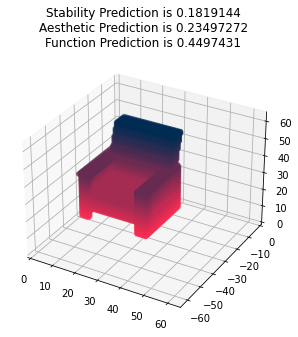

Generated output: 


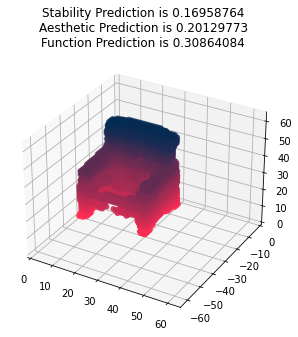

Epoch: 3, Training Loss: 44309.65625, Validation Loss: 43324.84375, Time: 33.0


In [ ]:
for each_batch in val_ds:
    preview_geometry = each_batch[0]
    break
mo_vae_train(train_ds, val_ds, preview_geometry, epochs)